<img src="./result/logo.png" alt="Drawing" align="left" style="width: 500px;"/>

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.metrics import auc, roc_curve, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

from keras import models, layers


%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Lending Club Loan Data Analysis and Modeling

Classification is one of two most common data science problems (another one is regression). For the supervised classification problem, imbalanced data is pretty common yet very challanging. For example, credit card fraud detection, disease classification, network intrusion and so on, are classification problem with imbalanced data. 

In this project, working with the Lending Club loan data, we hope to correctlly predict whether or not on loan will be default using the history data.

# Contents
1. Problem Statement
2. Data Exploration
3. Data Cleaning and Initial Feature Engineering
    - Feature transformation
    - Missing values
    - Feature transformation
    - Feature normalization
    - And so on ......
4. Visualization
5. Further Feature Engineering
6. Machine Learning
    - Logistic Regression
    - Random Forest
    - Deep Learning
7. Conclusions

# 1. Problem Statment

For companies like Lending Club, correctlly predicting whether or not one loan will be default is very important. In this project, using the historical data, more specifically, the Lending Club loan data from 2007 to 2015, we hope to build a machine learning model such that we can predict the chance of default for the future loans. 

As I will show later, this dataset is highly imbalanced and includes a lot of features, which makes this problem more challanging. 

# 2. Data Exploration

There are several ways to download the dataset, for example, you can go to Lending Club's [website](https://www.lendingclub.com/info/download-data.action), or you can go to [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data).

I will use the loan data from 2007 to 2015 as the training set (+ validation set), and use the data from 2016 as the test set.

In [2]:
# Load the training and test data set
train = pd.read_csv('./data/2007-2015-loan.csv', low_memory=False, encoding='ISO-8859-1')
test = pd.read_csv('./data/2016-loan.csv', low_memory=False, encoding='ISO-8859-1')

# There are 74 features in total
print('Train:\t', train.shape)
print('Test:\t', test.shape)

Train:	 (887379, 74)
Test:	 (434407, 74)


In [3]:
train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,NaN,NaN,35000,35000,35000.0,36 months,18.99%,1282.79,D,D4,...,63025.0,72.0,3.0,3.0,16542.0,71.0,34300,1.0,1.0,5.0
1,NaN,NaN,32000,32000,32000.0,36 months,5.32%,963.68,A,A1,...,35403.0,42.0,1.0,1.0,3442.0,33.0,35800,2.0,0.0,2.0
2,NaN,NaN,22000,22000,22000.0,36 months,6.49%,674.18,A,A2,...,39179.0,71.0,0.0,1.0,11746.0,67.0,90900,0.0,0.0,2.0
3,NaN,NaN,16300,16300,16300.0,36 months,9.75%,524.05,B,B3,...,14714.0,58.0,0.0,2.0,1969.0,65.0,20000,1.0,0.0,1.0
4,NaN,NaN,15000,15000,15000.0,36 months,11.47%,494.43,B,B5,...,71135.0,87.0,0.0,2.0,9883.0,60.0,63700,0.0,1.0,0.0


In [5]:
# Create a concise table for the data
train_dtype = train.dtypes.values
train_missing = train.isnull().sum().values
train_missing_ratio = train_missing / len(train)

test_dtype = test.dtypes.values
test_missing = test.isnull().sum().values
test_missing_ratio = test_missing / len(test)

# Calculate unique values
train_unique = []
test_unique = []
for name in train.columns:
    train_unique.append(train[name].unique().shape[0])
    test_unique.append(test[name].unique().shape[0])

# Useful information
tmp_map = {'Columns': train.columns, 'Train dtype': train_dtype, 'Train missing': train_missing, 
           'Train missing ratio': train_missing_ratio, 'Train unique': train_unique, 'Test dtype': test_dtype,
           'Test missing': test_missing, 'Test missing ratio': test_missing_ratio, 'Test unique': test_unique}
columns = ['Columns', 'Train dtype', 'Train missing', 'Train missing ratio', 'Train unique',
           'Test dtype', 'Test missing', 'Test missing ratio', 'Test unique']
df = pd.DataFrame(tmp_map, columns=columns)

pd.options.display.max_rows = 75
df

,Columns,Train dtype,Train missing,Train missing ratio,Train unique,Test dtype,Test missing,Test missing ratio,Test unique
0,id,int64,0,0.000000,887379,float64,434407,1.000000,1
1,member_id,int64,0,0.000000,887379,float64,434407,1.000000,1
2,loan_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
3,funded_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
4,funded_amnt_inv,float64,0,0.000000,9856,float64,0,0.000000,1549
5,term,object,0,0.000000,2,object,0,0.000000,2
6,int_rate,float64,0,0.000000,542,object,0,0.000000,140
7,installment,float64,0,0.000000,68711,float64,0,0.000000,42851
8,grade,object,0,0.000000,7,object,0,0.000000,7
9,sub_grade,object,0,0.000000,35,object,0,0.000000,35


We should notice some differences between the training and test set, and look into details. Some major difference are:
1. For test set, id, member_id, and url are totally missing, which is different from training set
2. For training set, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, inq_fi, total_cu_tl, and inq_last_12m	are almost missing in training set, which is different from test set
3. desc, mths_since_last_delinq, mths_since_last_record, mths_since_last_major_derog, annual_inc_joint, dti_joint, and verification_status_joint have large amount of missing values
4. There are multiple loan status, but we only concern whether or not the load is default

# 3. Data Cleaning and Initial Feature Engineering

### I. Transform feature `int_rate` and `revol_util` in test set

In [6]:
# Check the difference values for int_rate, revol_util
print('Item\t', 'int_rate', '\t', 'revol_util')
print('-' * 40)
print('Train:\t', train['int_rate'][0], '\t\t', train['revol_util'][0])
print('Test:\t', test['int_rate'][0], '\t', test['revol_util'][0])

Item	 int_rate 	 revol_util
----------------------------------------
Train:	 10.65 		 83.7
Test:	 18.99% 	 70.50%


In [7]:
# Using lambda function
test['int_rate'] = test['int_rate'].apply(lambda x: float(x[:-1]))

index = test[~test['revol_util'].isnull()].index
test.loc[index, 'revol_util'] = test.loc[index, 'revol_util'].apply(lambda x: float(x[:-1]))
test['revol_util'] = test['revol_util'].astype(float)

### II. Transform target values `loan_status`

In [8]:
# Check the target values
print('Train:\n', list(train['loan_status'].unique()))
print('\nTest:\n', list(test['loan_status'].unique()))

Train:
 ['Fully Paid', 'Charged Off', 'Current', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued']

Test:
 ['Current', 'Charged Off', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Default']


In [9]:
# Let's only keep the data that is not in process currentlly, for more details, refer to 
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-
drop_status = ['Issued']
train = train[~train['loan_status'].isin(drop_status)]
test = test[~test['loan_status'].isin(drop_status)]

In [10]:
# Treat this as a binary classification problem
maps = {'Current': 0, 'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
        'Does not meet the credit policy. Status:Fully Paid': 0, 
        'Does not meet the credit policy. Status:Charged Off': 1, 
       'In Grace Period': 0, 'Late (16-30 days)': 1, 'Late (31-120 days)': 1}
train['loan_status'] = train['loan_status'].apply(lambda x: maps[x])
test['loan_status'] = test['loan_status'].apply(lambda x: maps[x])

In [11]:
# Check the imbalance
train_default_ratio = np.round(len(train[train['loan_status'] == 1]) / len(train), 4)
train_nondefault_ratio = np.round(len(train[train['loan_status'] == 0]) / len(train), 4)
test_default_ratio = np.round(len(test[test['loan_status'] == 1]) / len(test), 4)
test_nondefault_ratio = np.round(len(test[test['loan_status'] == 0]) / len(test), 4)
print('Item\t', 'Default', '\t', 'Not Default')
print('-' * 40)
print('Train:\t', train_default_ratio, '\t', train_nondefault_ratio)
print('Test:\t', test_default_ratio, '\t', test_nondefault_ratio)

Item	 Default 	 Not Default
----------------------------------------
Train:	 0.0696 	 0.9304
Test:	 0.0363 	 0.9637


It's clear that our dataset is highly imbalanced.

In [12]:
# Create a concise table for the data
train_dtype = train.dtypes.values
train_missing = train.isnull().sum().values
train_missing_ratio = train_missing / len(train)

test_dtype = test.dtypes.values
test_missing = test.isnull().sum().values
test_missing_ratio = test_missing / len(test)

# Calculate unique values
train_unique = []
test_unique = []
for name in train.columns:
    train_unique.append(train[name].unique().shape[0])
    test_unique.append(test[name].unique().shape[0])

# Useful information
df = pd.DataFrame({'Columns': train.columns, 'Train dtype': train_dtype, 'Train missing': train_missing, 
                   'Train missing ratio': train_missing_ratio, 'Train unique': train_unique, 
                   'Test dtype': test_dtype, 'Test missing': test_missing, 
                   'Test missing ratio': test_missing_ratio, 'Test unique': test_unique}, 
                  columns=['Columns', 'Train dtype', 'Train missing', 'Train missing ratio', 'Train unique',
                           'Test dtype', 'Test missing', 'Test missing ratio', 'Test unique'])

df

,Columns,Train dtype,Train missing,Train missing ratio,Train unique,Test dtype,Test missing,Test missing ratio,Test unique
0,id,int64,0,0.000000,878919,float64,434407,1.000000,1
1,member_id,int64,0,0.000000,878919,float64,434407,1.000000,1
2,loan_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
3,funded_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
4,funded_amnt_inv,float64,0,0.000000,9856,float64,0,0.000000,1549
5,term,object,0,0.000000,2,object,0,0.000000,2
6,int_rate,float64,0,0.000000,541,float64,0,0.000000,140
7,installment,float64,0,0.000000,68291,float64,0,0.000000,42851
8,grade,object,0,0.000000,7,object,0,0.000000,7
9,sub_grade,object,0,0.000000,35,object,0,0.000000,35


### III. Drop useless features

In [13]:
# Drop the features that has too many missing values
useless = ['id', 'member_id', 'url', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 
           'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
           'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'desc', 
           'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 
           'annual_inc_joint', 'dti_joint', 'verification_status_joint']
train = train.drop(labels=useless, axis=1)
test = test.drop(labels=useless, axis=1)

In [14]:
# Drop meaningless features based on understanding
meaningless = ['emp_title', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'zip_code', 'title', 
               'grade', 'earliest_cr_line', 'last_credit_pull_d', 'policy_code']
train = train.drop(labels=meaningless, axis=1)
test = test.drop(labels=meaningless, axis=1)

In [15]:
_ = gc.collect()
print(train.shape, test.shape)

(878919, 40) (434407, 40)


Now, we have successfully reduce the features from 74 to 40. Next, let's focus on more detailed feature engineering

First, let's look at the data again. From the below table, we can see that:
* Most features are numerical, but there are severl categorical features.
* There are still some missing values among numerical and categorical features.

In [16]:
# Create a concise table for the data
train_dtype = train.dtypes.values
train_missing = train.isnull().sum().values
train_missing_ratio = train_missing / len(train)

test_dtype = test.dtypes.values
test_missing = test.isnull().sum().values
test_missing_ratio = test_missing / len(test)

# Calculate unique values
train_unique = []
test_unique = []
for name in train.columns:
    train_unique.append(train[name].unique().shape[0])
    test_unique.append(test[name].unique().shape[0])

# Useful information
df = pd.DataFrame({'Columns': train.columns, 'Train dtype': train_dtype, 'Train missing': train_missing, 
                   'Train missing ratio': train_missing_ratio, 'Train unique': train_unique, 
                   'Test dtype': test_dtype, 'Test missing': test_missing, 
                   'Test missing ratio': test_missing_ratio, 'Test unique': test_unique}, 
                  columns=['Columns', 'Train dtype', 'Train missing', 'Train missing ratio', 'Train unique',
                           'Test dtype', 'Test missing', 'Test missing ratio', 'Test unique'])

df

,Columns,Train dtype,Train missing,Train missing ratio,Train unique,Test dtype,Test missing,Test missing ratio,Test unique
0,loan_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
1,funded_amnt,float64,0,0.000000,1372,int64,0,0.000000,1533
2,funded_amnt_inv,float64,0,0.000000,9856,float64,0,0.000000,1549
3,term,object,0,0.000000,2,object,0,0.000000,2
4,int_rate,float64,0,0.000000,541,float64,0,0.000000,140
5,installment,float64,0,0.000000,68291,float64,0,0.000000,42851
6,sub_grade,object,0,0.000000,35,object,0,0.000000,35
7,emp_length,object,44194,0.050282,12,object,28214,0.064948,12
8,home_ownership,object,0,0.000000,6,object,0,0.000000,4
9,annual_inc,float64,4,0.000005,49121,float64,0,0.000000,27841


### IV. Feature transformation

Transform numerical values into categorical values

In [17]:
transform_featurs = ['total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 
                     'collections_12_mths_ex_med', 'acc_now_delinq', 'out_prncp', 'out_prncp_inv']
for name in transform_featurs:
    train[name] = (train[name] > 0).astype(str)
    test[name] = (test[name] > 0).astype(str)

Transform categorical values into numerical values (discrete)

In [18]:
# Transform sub_grade
sub_grade_encoder = LabelEncoder()
sub_grade_encoder.fit(train['sub_grade'])
train['sub_grade'] = sub_grade_encoder.transform(train['sub_grade'])
test['sub_grade'] = sub_grade_encoder.transform(test['sub_grade'])

In [19]:
# Transform emp_length (first fill NA value with mode)
mode = train['emp_length'].mode().values[0]
train['emp_length'] = train['emp_length'].fillna(value=mode)
test['emp_length'] = test['emp_length'].fillna(value=mode)

# Manually do encoding due to sort problems
emp_map = {'< 1 year': 0, '1 year': 1, '3 years': 2, '4 years': 3, '5 years': 4, '6 years': 5, 
           '2 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
train['emp_length'] = train['emp_length'].apply(lambda x: emp_map[x])
test['emp_length'] = test['emp_length'].apply(lambda x: emp_map[x])

### V. Fill missing values
* For numerical features, use median
* For categorical features, use mode (here, we don't have missing categorical values)

In [20]:
# Seperate numerical and categorical features (16 categorical features, 23 numerical features)
numerical_feature = train.select_dtypes(exclude=['object']).columns.drop('loan_status')
categorical_feature = train.select_dtypes(include=['object']).columns

print('Numerical:\t', len(numerical_feature))
print('Categorical:\t', len(categorical_feature))

Numerical:	 23
Categorical:	 16


In [21]:
# Fill numerical features with median
medians = train[numerical_feature].median(axis=0, skipna=True)
train[numerical_feature] = train[numerical_feature].fillna(value=medians)
test[numerical_feature] = test[numerical_feature].fillna(value=medians)

# 4. Visualization 

### I. Visualize categorical features

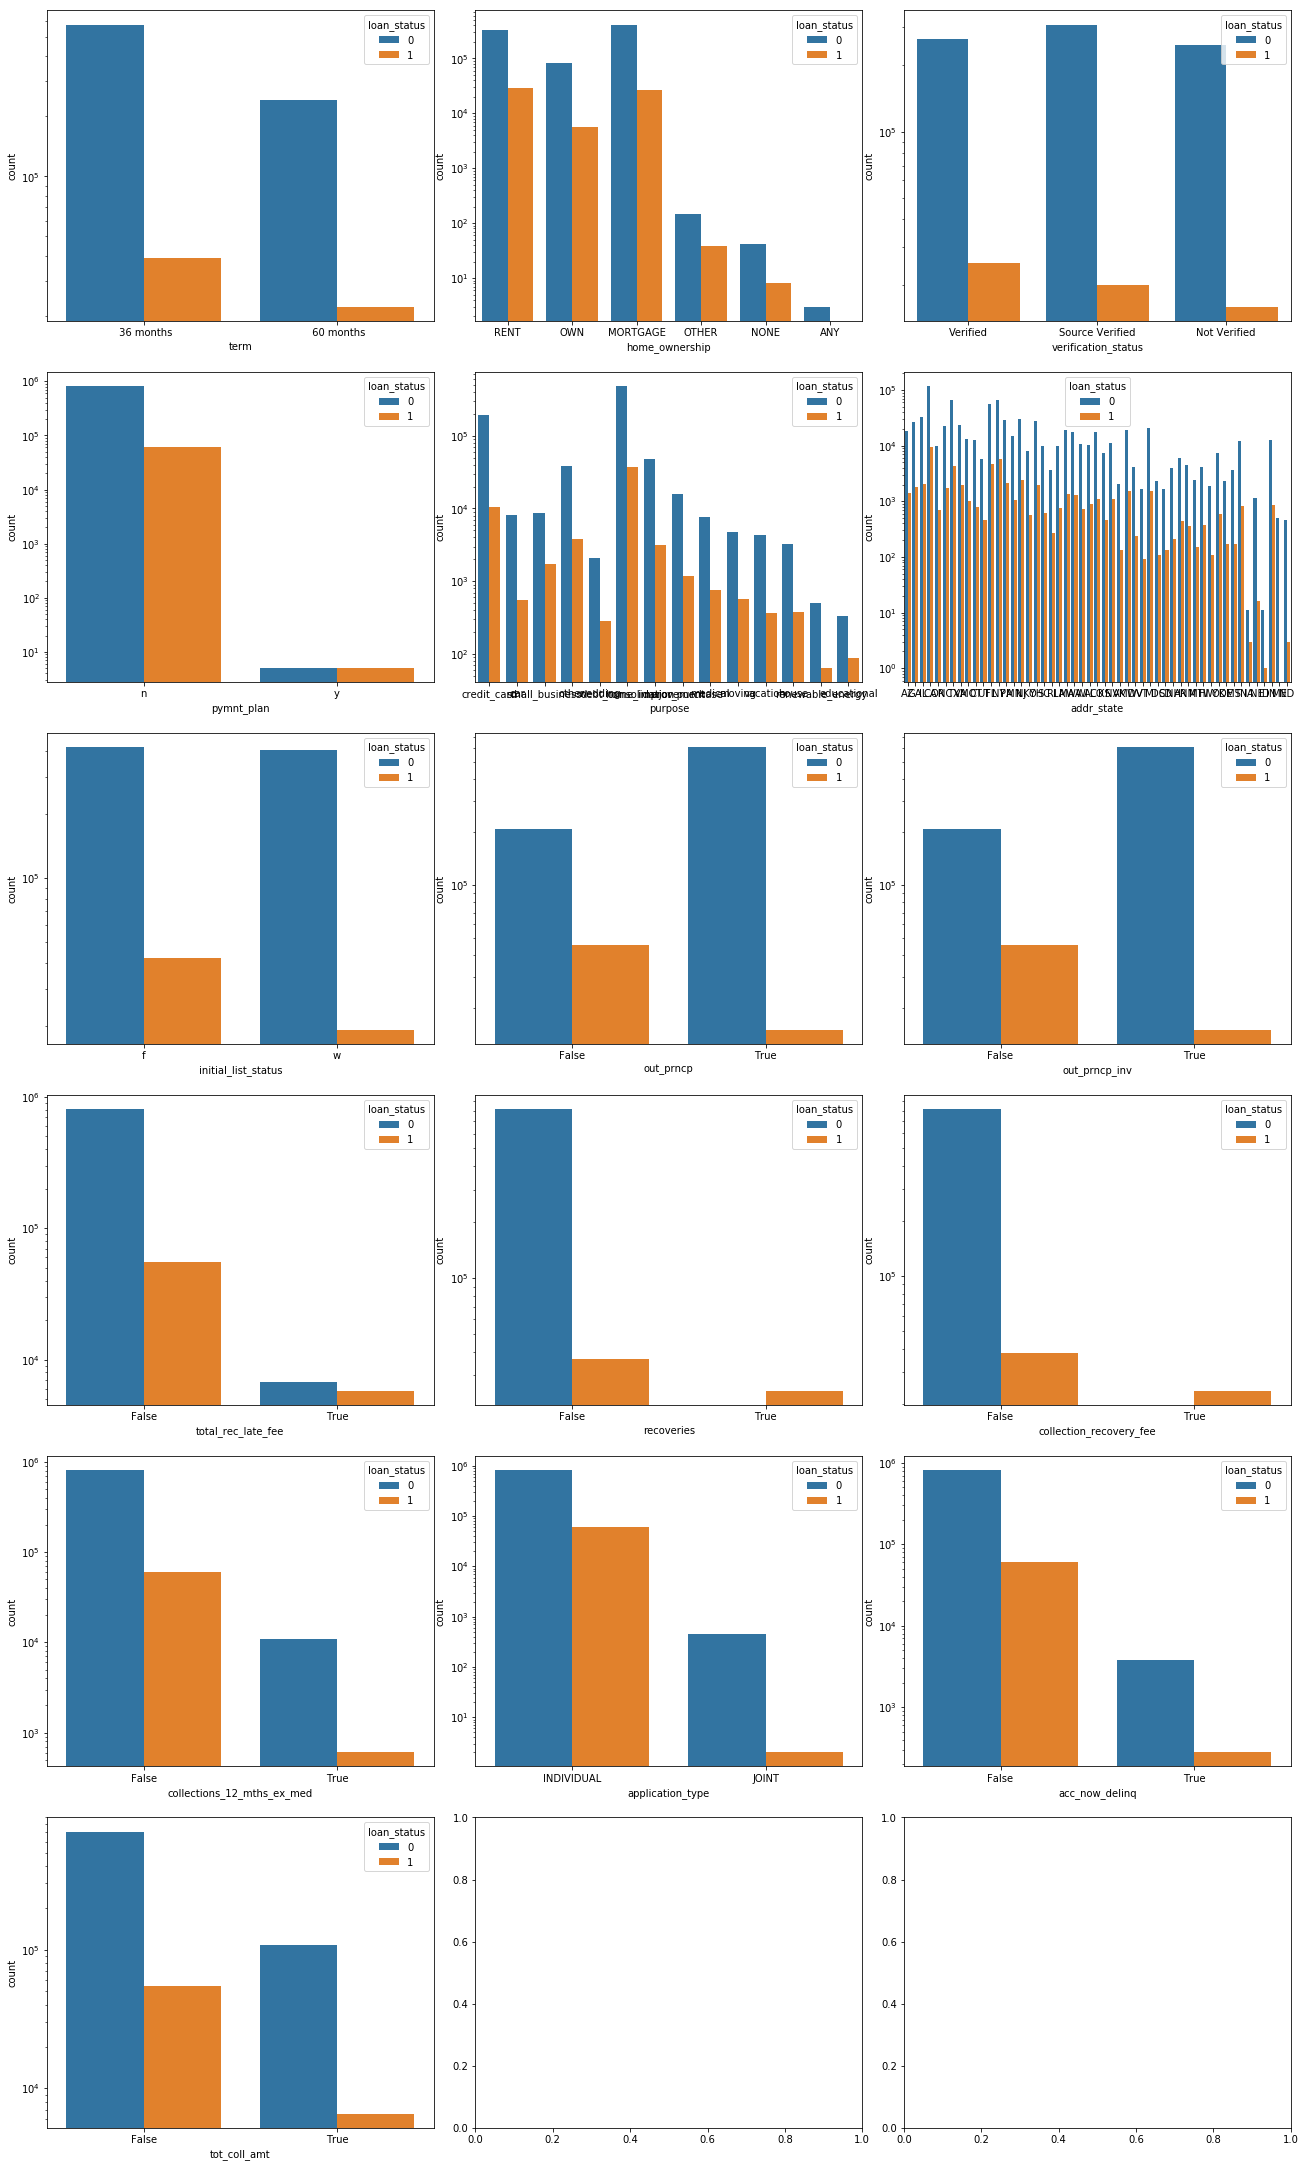

In [22]:
# For better visualization purpose, we set the y to be log scale
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18, 30))
plt.tight_layout(h_pad=3)
for i in range(len(categorical_feature)):
    name = categorical_feature[i]
    sns.countplot(x=name, hue='loan_status', data=train, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_yscale('log')
plt.show()
_ = gc.collect()

### II. Visualize numerical features

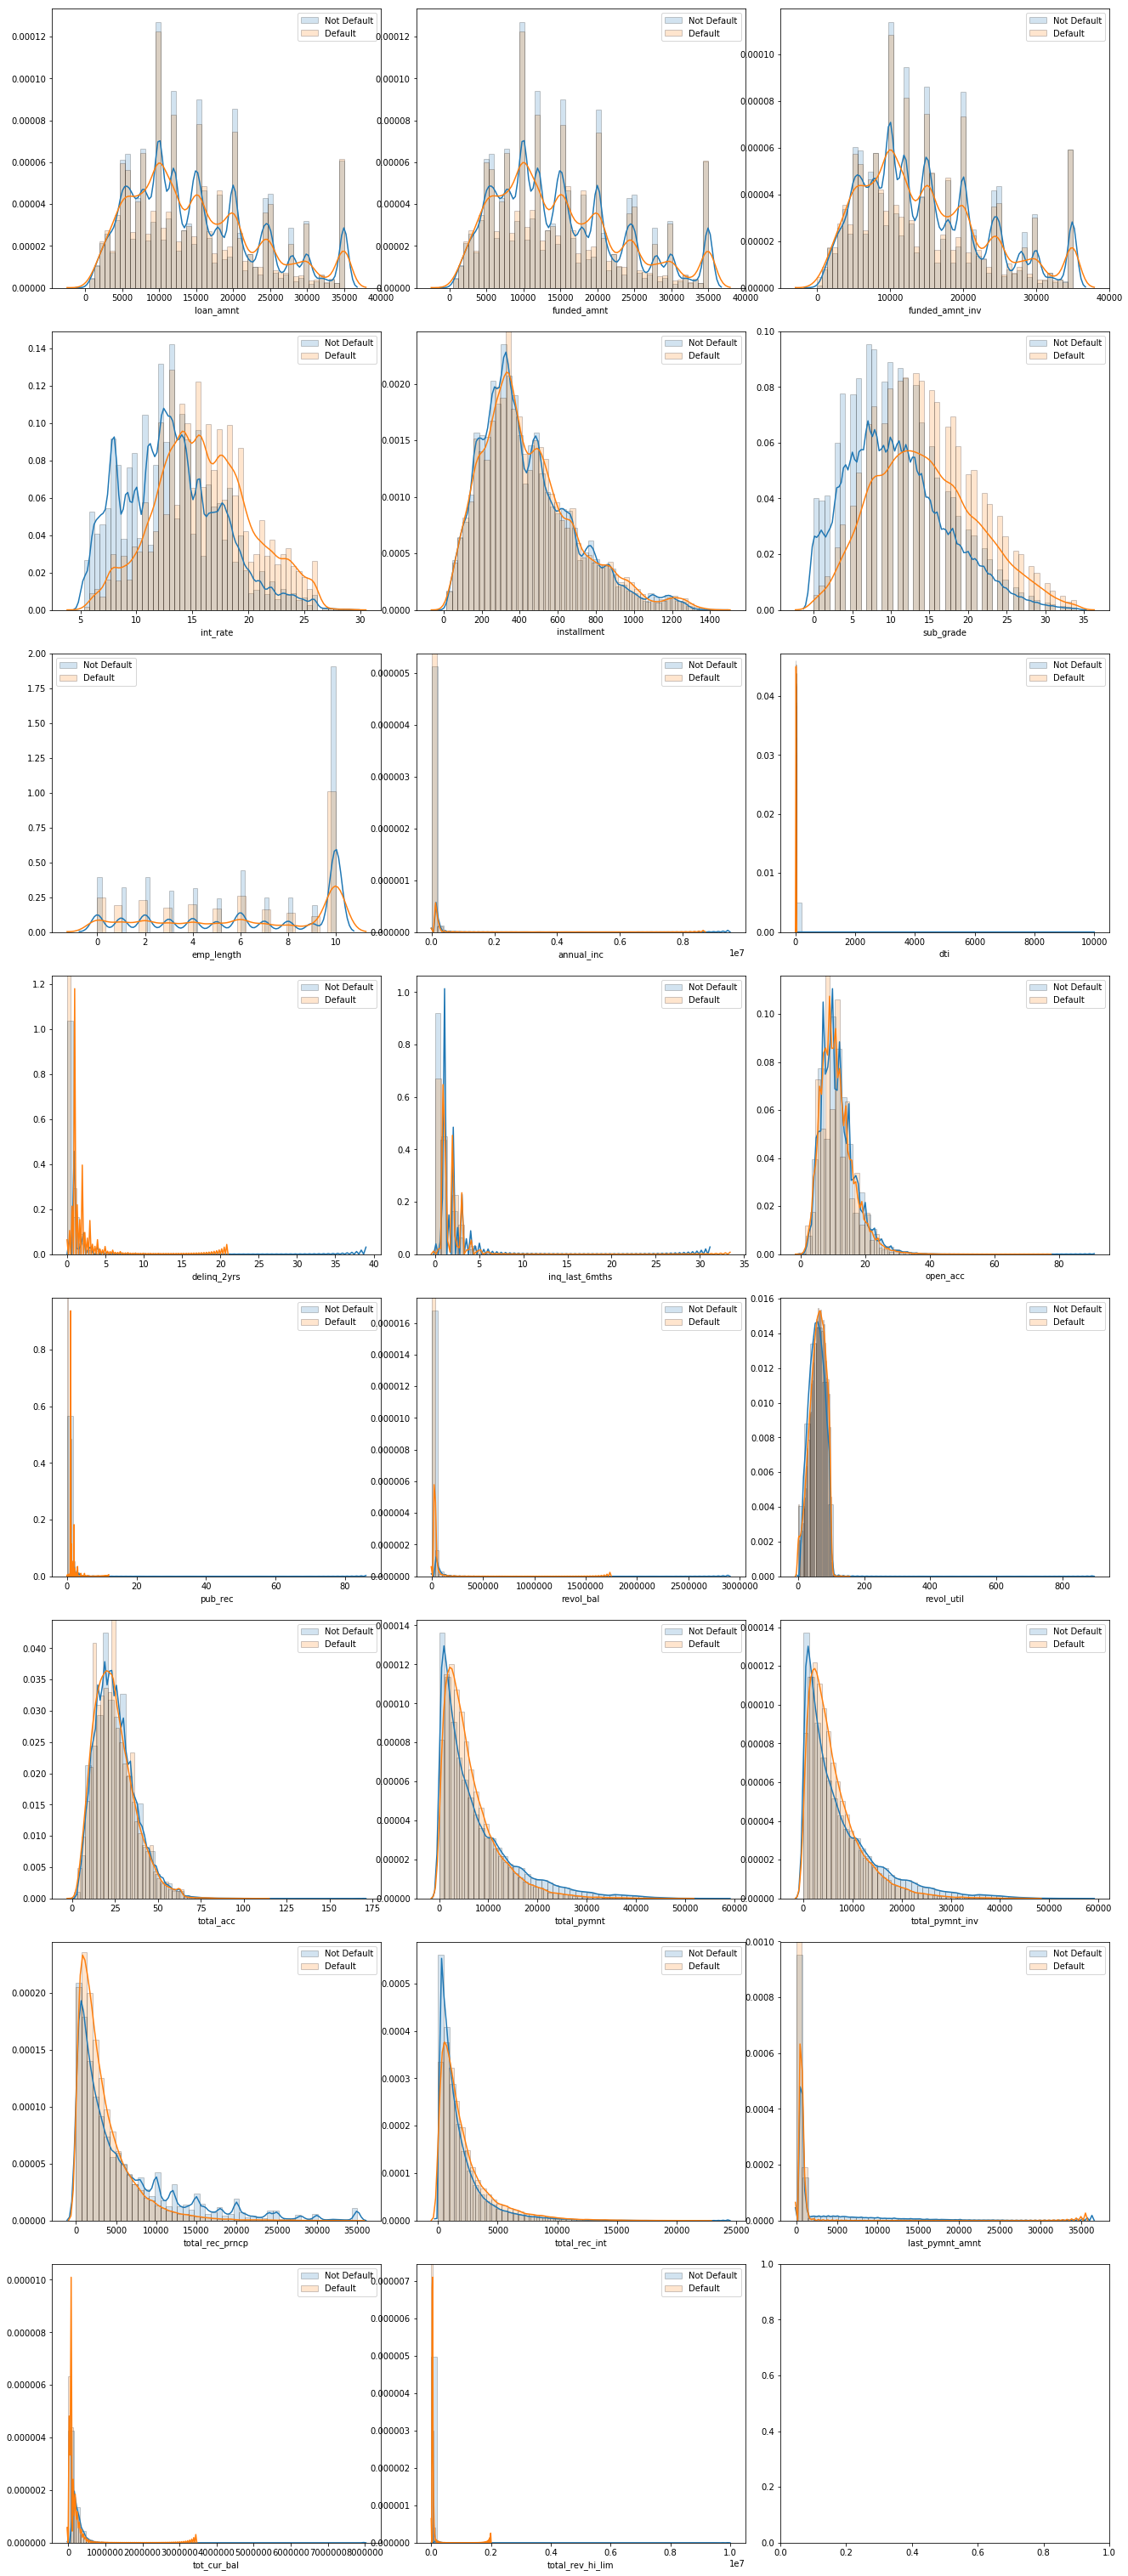

In [23]:
# Histogram of numerical values
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(18, 42))
plt.tight_layout(h_pad=3)
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
for i in range(len(numerical_feature)):
    name = numerical_feature[i]
    sns.distplot(train[train['loan_status'] == 0][name], label='Not Default',
                 hist_kws=hist_kws, ax=ax[i//3][i%3])
    sns.distplot(train[train['loan_status'] == 1][name], label='Default',
                 hist_kws=hist_kws, ax=ax[i//3][i%3])
    ax[i//3][i%3].legend()
plt.show()
_ = gc.collect()

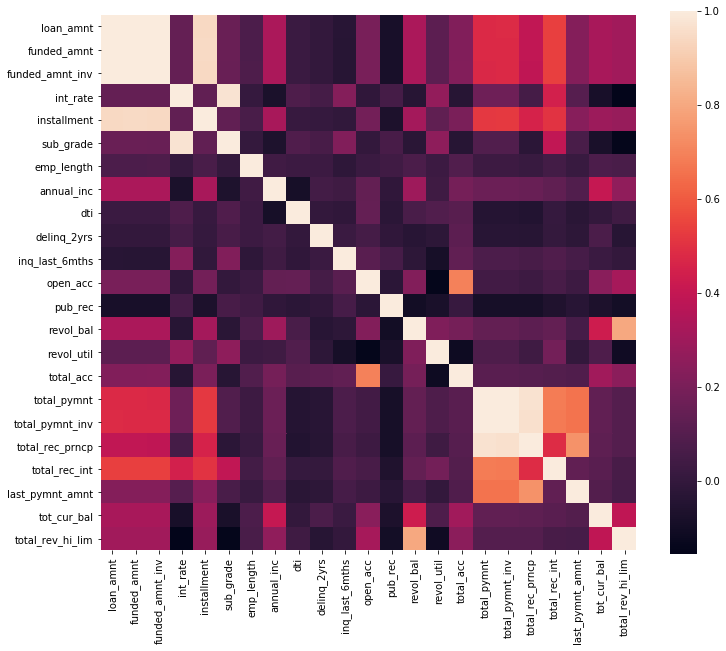

In [24]:
# Heatmap of the correlation
corr = train[numerical_feature].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, ax=ax)
plt.axis('image')
plt.show()

# 5. Further Feature Engineering

From the above heatmap and the categorical variable countplot, we can see that some feature has strong correlation
* loan_amnt, funded_amnt, funded_amnt_inv, installment
* int_rate, sub_grade
* total_pymnt, total_pymnt_inv, total_rec_prncp
* out_prncp, out_prncp_inv
* recoveries, collection_recovery_fee

We can drop some of them to reduce redundancy

In [25]:
# Drop redundant features
useless = ['funded_amnt', 'funded_amnt_inv', 'installment', 'sub_grade', 'total_pymnt_inv', 
           'total_rec_prncp', 'out_prncp_inv', 'collection_recovery_fee']
train = train.drop(useless, axis=1)
test = test.drop(useless, axis=1)

In [26]:
# Seperate numerical and categorical features (13 categorical features, 25 numerical features)
numerical_feature = train.select_dtypes(exclude=['object']).columns.drop('loan_status')
categorical_feature = train.select_dtypes(include=['object']).columns

print('Numerical:\t', len(numerical_feature))
print('Categorical:\t', len(categorical_feature))

Numerical:	 17
Categorical:	 14


Now, we only 14 categorical features, 17 numerical features. Let's check the correlation again.

In [27]:
print('Numerical features:', '\n', list(numerical_feature), '\n')
print('Categorical Features:', '\n', list(categorical_feature))

Numerical features: 
 ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim'] 

Categorical Features: 
 ['term', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'out_prncp', 'total_rec_late_fee', 'recoveries', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt']


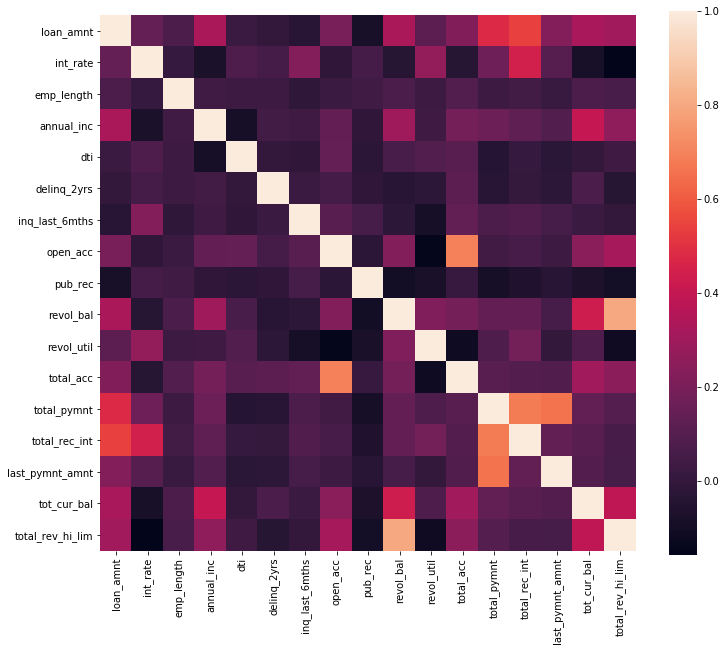

In [28]:
# Check the heatmap again
corr = train[numerical_feature].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, ax=ax)
plt.axis('image')
plt.show()

# 6. Machine Learning

After the above procedures, we are ready to build the predictive models. In this part, I explored three different models: Logistic regression, Random Forest, and Deep Learning.

I used to use scikit-learn a lot. But there is one problem with scikit-learn: you need to do one-hot encoding manually, which can sometimes dramatically increase the feature space. In this part, for logistic regression and random forest, I use H2O package, which has a better support with categorical features. For deep learning model, I use Keras with TensorFlow backend. 

In [29]:
# Define x and y variables
train = shuffle(train, random_state=42)
x = list(train.columns.drop('loan_status'))
y = 'loan_status'

train_y = train['loan_status'].values
test_y = test['loan_status'].values

In [30]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

# Transform to H2O Frame, and make sure the target variable is categorical
h2o_train = H2OFrame(train)
h2o_test = H2OFrame(test)

h2o_train['loan_status'] = h2o_train['loan_status'].asfactor()
h2o_test['loan_status'] = h2o_test['loan_status'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 hours 23 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.3
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_ubuntu_i3fmc7
H2O cluster total nodes:,1
H2O cluster free memory:,13.25 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### I. Logistic Regression

In [31]:
# Train logistic regression model with Lasso using grid search
hyper_parameters = {'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                    'lambda': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]}

# Create GLM model
glm = H2OGeneralizedLinearEstimator(family='binomial', balance_classes=True, 
                                    early_stopping=True, custom_metric_func='auc',
                                    keep_cross_validation_predictions=True, nfolds=5)

# Grid search
glm_grid = H2OGridSearch(glm, hyper_parameters, grid_id='GLM')
glm_grid.train(x=x, y=y, training_frame=h2o_train)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [32]:
# Get the grid search result, sorted by AUC
glm_models = glm_grid.get_grid(sort_by='auc', decreasing=True)

# Choose the best model
best_glm = glm_grid.models[0]

glm_models

      alpha    lambda     model_ids                 auc
0     [0.4]  [1.0E-8]  GLM_model_26  0.9185634530443624
1     [1.0]  [1.0E-8]  GLM_model_29  0.9185632770967199
2     [0.6]  [1.0E-8]  GLM_model_27  0.9185502569411996
3     [0.8]  [1.0E-7]  GLM_model_22  0.9185468019347856
4     [1.0]  [1.0E-7]  GLM_model_23  0.9185276144565876
5     [0.6]  [1.0E-7]  GLM_model_21  0.9184673630934534
6     [0.4]  [1.0E-7]  GLM_model_20  0.9184621094811553
7     [0.2]  [1.0E-7]  GLM_model_19  0.9183918727394998
8     [1.0]  [1.0E-6]  GLM_model_17  0.9181822524624031
9     [0.6]  [1.0E-6]  GLM_model_15  0.9180828876305297
10    [0.2]  [1.0E-6]  GLM_model_13  0.9180306339792738
11    [0.8]  [1.0E-6]  GLM_model_16  0.9180152443775121
12    [0.2]  [1.0E-8]  GLM_model_25  0.9180147235209177
13    [0.4]  [1.0E-6]  GLM_model_14  0.9180054217435635
14    [1.0]  [1.0E-5]  GLM_model_11  0.9179048934823919
15    [0.8]  [1.0E-5]  GLM_model_10  0.9176969530934961
16    [0.6]  [1.0E-5]   GLM_model_9  0.917613295

In [33]:
# Make predictions
glm_train_pred = best_glm.predict(h2o_train).as_data_frame()['p1'].values
glm_test_pred = best_glm.predict(h2o_test).as_data_frame()['p1'].values

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'application_type' has levels not trained on: [DIRECT_PAY]
  warnings.warn(w)


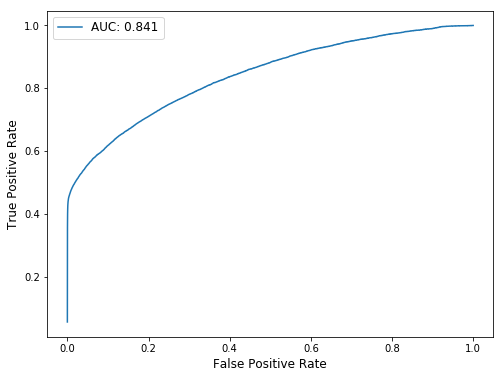

In [35]:
# Build the ROC curve
glm_fpr, glm_tpr, _ = roc_curve(test_y, glm_test_pred)
glm_auc = np.round(auc(glm_fpr, glm_tpr), 3)
np.save('./result/glm_fpr.npy', glm_fpr)
np.save('./result/glm_tpr.npy', glm_tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(glm_fpr, glm_tpr, label='AUC: ' + str(glm_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [36]:
# Log-loss
print('Train:\t', log_loss(train_y, glm_train_pred))
print('Test:\t', log_loss(test_y, glm_test_pred))

Train:	 0.10566346393281262
Test:	 0.10075545308375666


### II. Random Forest

In [37]:
# Train random forest model using grid search
hyper_parameters = {'max_depth': [15, 20], 
                    'min_rows': [3, 5, 7]}

# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=200, stopping_rounds=5, nfolds=5, 
                              stopping_metric='auc', keep_cross_validation_predictions=True)

# Grid search
rf_grid = H2OGridSearch(rf, hyper_parameters, grid_id='DRF')
rf_grid.train(x=x, y=y, training_frame=h2o_train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [38]:
# Get the grid search result, sorted by AUC
rf_models = rf_grid.get_grid(sort_by='auc', decreasing=True)

# Choose the best model
best_rf = rf_grid.models[0]

rf_models

    max_depth min_rows    model_ids                 auc
0          20      3.0  DRF_model_1  0.9469033117072501
1          20      5.0  DRF_model_3  0.9467724155066762
2          20      7.0  DRF_model_5  0.9463241491685624
3          15      7.0  DRF_model_4  0.9447209087240975
4          15      3.0  DRF_model_0  0.9444212715882326
5          15      5.0  DRF_model_2  0.9442407675375812


In [39]:
# Make prediction
rf_train_pred = best_rf.predict(h2o_train).as_data_frame()['p1'].values
rf_test_pred = best_rf.predict(h2o_test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'application_type' has levels not trained on: [DIRECT_PAY]
  warnings.warn(w)


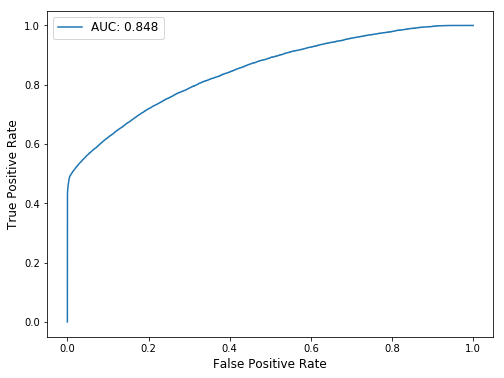

In [41]:
# Build the ROC curve
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_test_pred)
rf_auc = np.round(auc(rf_fpr, rf_tpr), 3)
np.save('./result/rf_fpr.npy', rf_fpr)
np.save('./result/rf_tpr.npy', rf_tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(rf_fpr, rf_tpr, label='AUC: ' + str(rf_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [42]:
# Log-loss
print('Train:\t', log_loss(train_y, rf_train_pred))
print('Test:\t', log_loss(test_y, rf_test_pred))

Train:	 0.056370465400420955
Test:	 0.10318279608734049


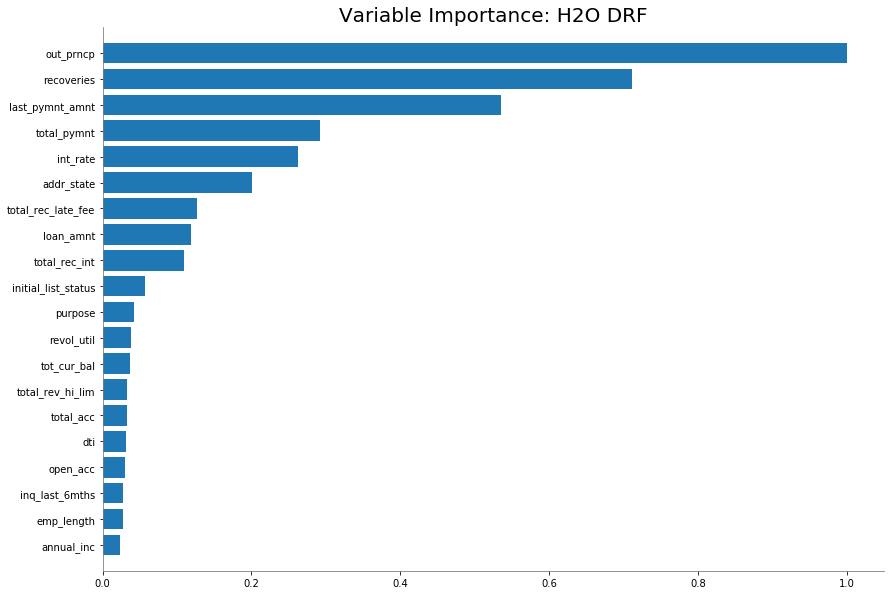

In [43]:
# Feature importance
best_rf.varimp_plot(num_of_features=20)
plt.show()

In [44]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a8e2 closed.


### III. Deep Learning

In this part, let's manually build a fully-connected neural network (NN) model to finish the classification task.

In [45]:
# Feature Normalization
mean = train[numerical_feature].mean()
std = train[numerical_feature].std()
train[numerical_feature] = (train[numerical_feature] - mean) / std
test[numerical_feature] = (test[numerical_feature] - mean) / std

# Dummy encoding
tmp_data = pd.concat([train[categorical_feature], test[categorical_feature]], axis=0)
dummy_data = pd.get_dummies(tmp_data)
train_dummy = dummy_data[:len(train)]
test_dummy = dummy_data[len(train):]

# Get train, test data and target
train_data = pd.concat([train[numerical_feature], train_dummy], axis=1).values
train_target = train['loan_status'].values
test_data = pd.concat([test[numerical_feature], test_dummy], axis=1).values
test_target = test['loan_status'].values

In [46]:
# Define NN model
def build_model(data):
    # build a NN with input-layer1-layer2-output structure
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy')
    return model


def kfold(data, target, k, num_epochs=100, batch_size=128):
    """ function to perform k-fold cross validation """
    n = len(data) // k
    
    # Keep recording the training and validation loss
    train_loss = np.zeros((k, num_epochs))
    val_loss = np.zeros((k, num_epochs))

    for i in range(k):
        print('Processing cross-validation round #', i + 1)
        
        # Get the train and validation set
        val_x = data[i * n: (i + 1) * n]
        val_y = target[i * n: (i + 1) * n]
        
        train_x = np.concatenate([data[: i * n], data[(i + 1) * n:]], axis=0)
        train_y = np.concatenate([target[: i * n], target[(i + 1) * n:]], axis=0)
        
        # Over sampling training set
        ros = RandomOverSampler(ratio='minority', random_state=42)
        train_x_resampled, train_y_resampled = ros.fit_sample(train_x, train_y)
        
        # Build and train NN model
        model = build_model(data)
        history = model.fit(train_x_resampled, train_y_resampled, epochs=num_epochs, verbose=0, 
                            validation_data=(val_x, val_y), batch_size=batch_size)
        
        # Retrieve the training and validation history
        
        train_loss[i] = history.history['loss']
        val_loss[i] = history.history['val_loss']
        
    return train_loss, val_loss

In [53]:
# Begin 5-fold cross validataion
num_epochs = 100
train_loss, val_loss = kfold(data=train_data, target=train_target, k=5, 
                             num_epochs=num_epochs, batch_size=1024)

Processing cross-validation round # 1
Processing cross-validation round # 2
Processing cross-validation round # 3
Processing cross-validation round # 4
Processing cross-validation round # 5


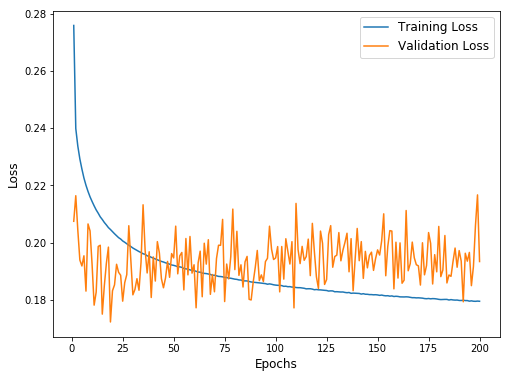

In [55]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, num_epochs + 1), np.mean(train_loss, axis=0), label='Training Loss')
ax.plot(range(1, num_epochs + 1), np.mean(val_loss, axis=0), label='Validation Loss')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [57]:
# Over sampling training set
ros = RandomOverSampler(ratio='minority', random_state=42)
train_x_resampled, train_y_resampled = ros.fit_sample(train_data, train_target)

# Re-fit the model with the best epochs
nn_model = build_model(train_data)
history = nn_model.fit(train_x_resampled, train_y_resampled, epochs=20, verbose=0, batch_size=1024)

In [58]:
# Make prediction
nn_train_pred = nn_model.predict(train_data)
nn_test_pred = nn_model.predict(test_data)

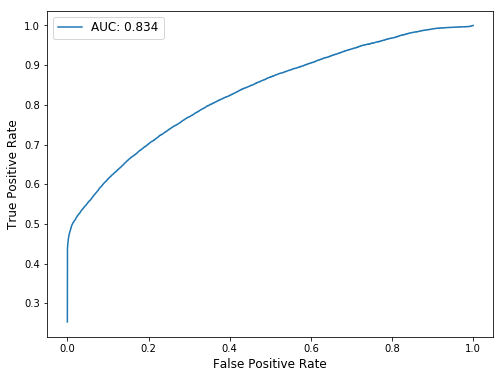

In [60]:
# Build the ROC curve
nn_fpr, nn_tpr, _ = roc_curve(test_y, nn_test_pred)
nn_auc = np.round(auc(nn_fpr, nn_tpr), 3)
np.save('./result/nn_fpr.npy', nn_fpr)
np.save('./result/nn_tpr.npy', nn_tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nn_fpr, nn_tpr, label='AUC: ' + str(nn_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

# 7. Conclusions

From our above analysis, we can see that for the above three algorithms: Logistic Regression, Random Forest, and Neural Networks, their performance on the test set is pretty similar. Based on our simple analysis and grid search, Random Forest gives the best result. 

There are a lot of other methods, such as AdaBoost and XGBoost, and we can tune a lot of parameters for different models, especially for Neural Networks. Here, I didn't explore all possible algorithms and conduct comprehensive parameter tune.

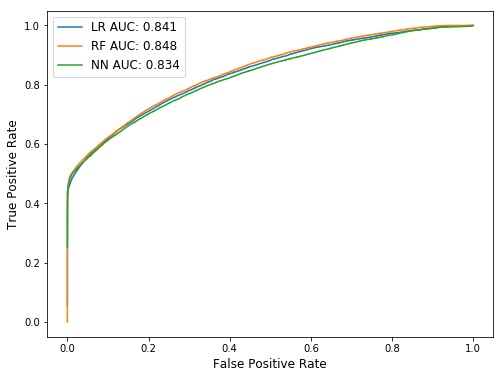

In [61]:
# Visualize the three different methods
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(glm_fpr, glm_tpr, label='LR AUC: ' + str(glm_auc))
ax.plot(rf_fpr, rf_tpr, label='RF AUC: ' + str(rf_auc))
ax.plot(nn_fpr, nn_tpr, label='NN AUC: ' + str(nn_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()